In [10]:
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from timeit import default_timer as timer

#OwnFonction
from fonctionIA import *

## Variables

In [11]:
num_trees = 100
test_size = 0.10
seed      = 9
train_path= "dataset/train"
test_path = "dataset/test"
h5_data   = 'output/data.h5'
h5_labels = 'output/labels.h5'
scoring   = "accuracy"

In [12]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (240, 532)
[STATUS] labels shape: (240,)
[STATUS] training started...


## Split train and test

In [13]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),np.array(global_labels),test_size=test_size,random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (216, 532)
Test data   : (24, 532)
Train labels: (216,)
Test labels : (24,)


LR: 0.639177 (0.117976)
LDA: 0.449567 (0.083489)
KNN: 0.523810 (0.051704)
CART: 0.491558 (0.077303)
RF: 0.616234 (0.123464)
NB: 0.545238 (0.099936)
SVM: 0.588312 (0.101919)


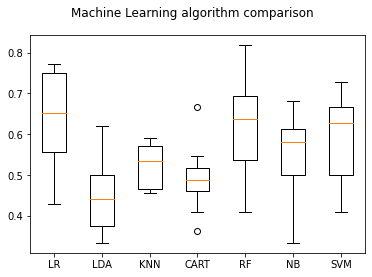

In [14]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot().set_xticklabels(names)
pyplot.boxplot(results)
pyplot.show()

## Test random Forest algorithm

In [15]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
fixed_size = tuple((500,500))

In [17]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False


def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        #title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

RandomForestClassifier(random_state=9)
1
0
0
0
0
0
0
0
2
2
2
2
1
1


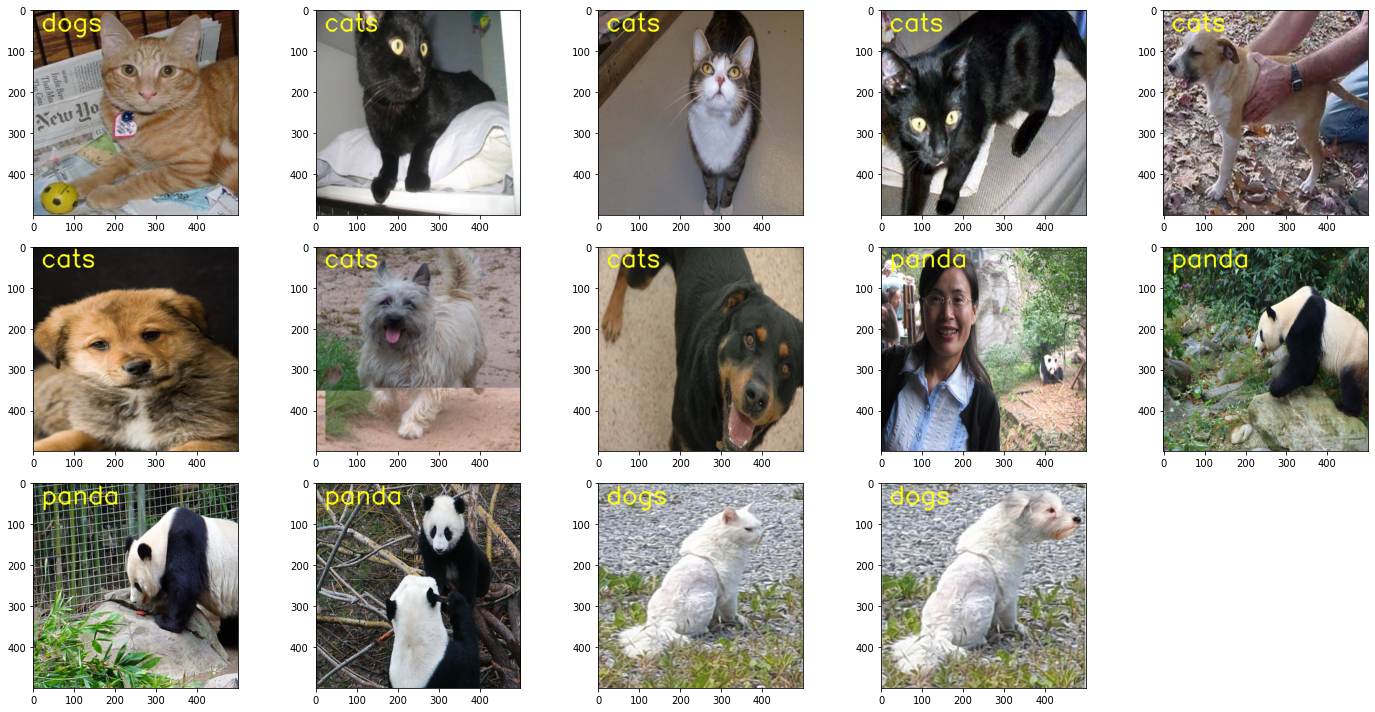

In [20]:
# create the model - Random Forests
nothing,clf  = models[4]
print(clf)
# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

image_list = []
# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    #Extraction des différentes features à partir des fonctions
    fv_hu_moments = hu_moments(image)
    fv_haralick   = haralick(image)
    fv_histogram  = histogram(image)

    #Concatène toutes les features ensemble
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # predict label of test image
    prediction = clf.predict([global_feature])[0]

    print(prediction)
    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,50), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (20,255,255), 3)
    image_list.append(image)

show_image_list(image_list, None,num_cols=5, figsize=(20, 10), grid=False, title_fontsize=20)


